# Fig 4: Visualizing noise decomposition

In [1]:
import sys
# sys.path.insert(0, 'src/')    # adds monod to path
sys.path.insert(0, '/home/ggorin/projects/monod/src/')
import monod
from monod import analysis

import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA

import copy

-----------------------

## Preliminaries: Retrieve raw data and model fit parameters

**IMPORTANT:** Assumes relevant raw data and Monod fits are contained in a folder called 'monod_fit_package'. (I got it from this google drive link: https://drive.google.com/file/d/1AgniMZMumGnOCtjuwMVRi9Sszj-QCRAc/view?ts=666f5eff&exids=71471476,71471470)
Change this in the cell below.

Also assumes the src folder of Monod is in the same directory as this notebook.
Finally, results will be saved in a 'results' folder, and when figures are generated there will be an error if this folder doesn't exist in main directory.

### Get raw data

In [2]:
# NOTE: I AM ASSUMING ALL THE RELEVANT STUFF IS IN HERE
# THIS IS THE FOLDER I GOT FROM GOOGLE DRIVE, CONTAINS DATA AND PARAM FITS
# dir_string = 'monod_fit_package/gg_230328_026_allen_celltypes_1'  # specify location of data
# dir_string=
dir_string = './fits/gg_230328_026_allen_celltypes_1'

#############
# Get data where cell types are pooled

sd_string = dir_string+'/allen_B08_Glutamatergic/raw.sd'
sd = monod.analysis.load_search_data(sd_string)

S_N = copy.deepcopy(sd.layers[0])  # raw data: nascent, all cell types together
S_M = copy.deepcopy(sd.layers[1])  # raw data: mature, all cell types together

print("Successfully obtained raw nascent and mature, pooled cell types.")
# relevant numbers
n_genes, n_cells = S_N.shape
n_cell_types = 6

print("n_genes:", n_genes); print("n_cells:", n_cells); print("n_cell_types:", n_cell_types); print()


#############
# Get data for each cell type

raw_names = ['L23IT','L5IT','L6IT','L56NP', 'L6CT', 'L6b']

S_N_cell, S_M_cell = [], []
n_cells_per = np.zeros(n_cell_types)  # stores number of cells of each type, np.sum(n_cells_per) = n_cells

for i in range(n_cell_types):
    name = raw_names[i]
    print("Extracting data from ", name, " cells...")
    
    string = dir_string+'/allen_B08_'+name+'/raw.sd'
    sd_ = monod.analysis.load_search_data(string)

    S_N_cell.append(copy.deepcopy(sd_.layers[0]))  # raw data: nascent, specific cell type
    S_M_cell.append(copy.deepcopy(sd_.layers[1]))  # raw data: mature, specific cell type

    n_cells_per[i] = sd_.layers[0].shape[1]
pi = n_cells_per/n_cells

print("Successfully obtained raw nascent and mature, organized by cell type.\n")
print("number of cells of each type:", n_cells_per); print("fraction of cells that are each type:", pi)

Successfully obtained raw nascent and mature, pooled cell types.
n_genes: 2951
n_cells: 5343
n_cell_types: 6

Extracting data from  L23IT  cells...
Extracting data from  L5IT  cells...
Extracting data from  L6IT  cells...
Extracting data from  L56NP  cells...
Extracting data from  L6CT  cells...
Extracting data from  L6b  cells...
Successfully obtained raw nascent and mature, organized by cell type.

number of cells of each type: [ 823. 2382.  489.  250. 1333.   66.]
fraction of cells that are each type: [0.15403331 0.44581696 0.09152162 0.04679019 0.24948531 0.01235261]


### Get model fits

In [3]:
dataset_names = ['allen_B08_'+y  for y in raw_names]   
result_strings = [dir_string+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]

sr_arr = []
for i in range(n_cell_types):
    print("Extracting model fits for ", raw_names[i], " cells...")
    sr = monod.analysis.load_search_results(result_strings[i])
    
    sr_arr.append(sr)
print("Successfully collected model fit objects.")

Extracting model fits for  L23IT  cells...
Extracting model fits for  L5IT  cells...
Extracting model fits for  L6IT  cells...
Extracting model fits for  L56NP  cells...
Extracting model fits for  L6CT  cells...
Extracting model fits for  L6b  cells...
Successfully collected model fit objects.


In [5]:
# Get parameters from model fits. For now assume bursty model with catalysis tech noise.

# model params | note: assume k = 1 since we are using ss data
b, beta, gamma = np.zeros((n_cell_types, n_genes)), np.zeros((n_cell_types, n_genes)), np.zeros((n_cell_types, n_genes)) # bio params
lamb_N_cell, lamb_M_cell = np.zeros((n_cell_types, n_genes)), np.zeros((n_cell_types, n_genes))  # tech noise param


li = sr_arr[-1].samp_optimum_ind    # loc of best fit params
for j in range(n_cell_types):  
    print("Extracting best fit parameters for ", raw_names[j], " cells...")
    
    p = 10**sr_arr[j].param_estimates[li]   # extract bio param estimates
    b[j], beta[j], gamma[j] = p.T           # burst size, splicing rate, mature deg rate
    
    lamb_N_cell[j] = 10**sr_arr[j].regressor[li].T[0]  # extract tech noise param estimates; assuming catalysis model, whose param is lambda
    lamb_M_cell[j] = 10**sr_arr[j].regressor[li].T[1] 
lamb_N = lamb_N_cell[0]; lamb_M = lamb_M_cell[0]      # tech noise params identical across cell types, just take first one
lamb = [lamb_N, lamb_M]

print("Successfully extracted best fit parameters for all cell types.")

Extracting best fit parameters for  L23IT  cells...
Extracting best fit parameters for  L5IT  cells...
Extracting best fit parameters for  L6IT  cells...
Extracting best fit parameters for  L56NP  cells...
Extracting best fit parameters for  L6CT  cells...
Extracting best fit parameters for  L6b  cells...
Successfully extracted best fit parameters for all cell types.


--------------------

## 0. Useful functions that do most of the work

### Transform raw data appropriately

In [6]:
# helper function for implementing specific transforms
def get_transformed_data(S, S_cell, transform, params=None):
    S_N, S_M = S
    S_N_cell, S_M_cell = S_cell
    
    S_trans = transform(S, params)  # transform pooled cell data

    S_N_cell_trans, S_M_cell_trans = [], []
    for i in range(n_cell_types):   # transform cell-type-separated data
        S_N_trans_, S_M_trans_ = transform([S_cell[0][i], S_cell[1][i]], params)
        S_N_cell_trans.append(S_N_trans_); S_M_cell_trans.append(S_M_trans_)
    
    S_cell_trans = [S_N_cell_trans, S_M_cell_trans]
    return S_trans, S_cell_trans

# transform; logp1 only
def trans_logp1(S, params):
    S_N, S_M = S
    
    S_N_trans = np.log( S_N + 1 )
    S_M_trans = np.log( S_M + 1 )
    return [S_N_trans, S_M_trans]

# transform; proportional fitting. C_S assumed already calculated
def trans_PF(S, params):
    S_N, S_M = S
    C_S = params['C_S']

    denom = np.sum(S_N + S_M, axis=0)
    S_N_trans = C_S*S_N*(1/denom[None,:])
    S_M_trans = C_S*S_M*(1/denom[None,:])

    return [S_N_trans, S_M_trans]
    
# transform; given a previously defined PCA transform, apply it
def trans_PCA(S, params):
    S_N, S_M = S
    
    pca_transformer = params['pca_transformer']
    ####
    S_N_trans = pca_transformer.inverse_transform(pca_transformer.transform(S_N.T)).T
    S_M_trans = pca_transformer.inverse_transform(pca_transformer.transform(S_M.T)).T
    return [S_N_trans, S_M_trans]

# transform; umap. PCA and umap are combined here 
def trans_umap(S, params):
    S_N, S_M = S
    umap_transformer, pca_transformer = params['umap_transformer'], params['pca_transformer']

    S_N_50D = pca_transformer.transform(S_N.T).T
    S_M_50D = pca_transformer.transform(S_M.T).T

    print(S_N_50D.shape)    # function is slow enough that print statements can be used as rough time progress markers
    
    S_N_umap = umap_transformer.transform(S_N_50D.T)
    S_M_umap = umap_transformer.transform(S_M_50D.T)

    print(S_N_umap.shape)
    
    S_N_trans = pca_transformer.inverse_transform(umap_transformer.inverse_transform(S_N_umap)).T
    S_M_trans = pca_transformer.inverse_transform(umap_transformer.inverse_transform(S_M_umap)).T

    return [S_N_trans, S_M_trans]


####

# PCA, done separately to nascent and mature
def trans_PCAsep(S, params):
    S_N, S_M = S
    
    pca_transformer_N, pca_transformer_M = params['pca_transformer_N'], params['pca_transformer_M']
    ####
    S_N_trans = pca_transformer_N.inverse_transform(pca_transformer_N.transform(S_N.T)).T
    S_M_trans = pca_transformer_M.inverse_transform(pca_transformer_M.transform(S_M.T)).T
    return [S_N_trans, S_M_trans]

### Get relevant moments of data: both empirical and model-based

In [7]:
# get low-order moments given (bursty, autocatalysis tech noise) model
# This approach only uses model fit parameters.
def get_moments_modelbased(b, beta, gamma, lamb_N, lamb_M):
    # bio means, fixed cell types; (n_types, n_genes)
    mu_N_cell = b/beta; mu_M_cell = b/gamma
    
    # bio means, averaged over cell-cell variation
    mu_N = np.sum(pi[:,None]*mu_N_cell, axis=0)
    mu_M = np.sum(pi[:,None]*mu_M_cell, axis=0)
    
    # bio cov matrices, fixed cell types; (n_types, n_genes)
    Sig_N_cell = mu_N_cell*(1 + b)
    Sig_NM_cell = mu_N_cell*(beta/(beta + gamma))
    Sig_M_cell = mu_M_cell*(1 + b*(beta/(beta + gamma)))
    
    # bio cov matrices, averaged over cell-cell variation
    Sig_N = np.sum(pi[:,None]*Sig_N_cell, axis=0) + np.sum(pi[:,None]*((mu_N_cell - mu_N[None,:])**2), axis=0)
    Sig_NM = np.sum(pi[:,None]*Sig_NM_cell, axis=0) + np.sum(pi[:,None]*(mu_N_cell - mu_N[None,:])*(mu_M_cell - mu_M[None,:]), axis=0)
    Sig_M = np.sum(pi[:,None]*Sig_M_cell, axis=0) + np.sum(pi[:,None]*((mu_M_cell - mu_M[None,:])**2), axis=0)

    mom = [mu_N, mu_M, Sig_N, Sig_NM, Sig_M]
    mom_cell = [mu_N_cell, mu_M_cell, Sig_N_cell, Sig_NM_cell, Sig_M_cell]
    return mom, mom_cell

# =============================================

# get low-order moments given data
# This approach only uses data---no model fit info used.
def get_moments_empirical(S, S_cell):
    S_N, S_M = S
    S_N_cell, S_M_cell = S_cell

    # get empirical moments of pooled cell type data
    mu_N = np.mean(S_N, axis=1); mu_M = np.mean(S_M, axis=1)
    
    Sig_N = np.mean( (S_N - mu_N[:,None])**2, axis=1 )
    Sig_NM = np.mean( (S_N - mu_N[:,None])*(S_M - mu_M[:,None]), axis=1)
    Sig_M = np.mean( (S_M - mu_M[:,None])**2, axis=1 )

    mu_N_cell, mu_M_cell = np.zeros((n_cell_types, n_genes)), np.zeros((n_cell_types, n_genes))
    Sig_N_cell, Sig_NM_cell, Sig_M_cell = np.zeros((n_cell_types, n_genes)), np.zeros((n_cell_types, n_genes)), np.zeros((n_cell_types, n_genes))
    for i in range(n_cell_types):  # get empirical moments of cell-type-separated data
        S_N_, S_M_ = S_N_cell[i], S_M_cell[i]
                                                                                                                       
        mu_N_ = np.mean(S_N_, axis=1); mu_M_ = np.mean(S_M_, axis=1)
        mu_N_cell[i] = mu_N_; mu_M_cell[i] = mu_M_
             
        Sig_N_cell[i] = np.mean( (S_N_ - mu_N_[:,None])**2, axis=1 )
        Sig_NM_cell[i] = np.mean( (S_N_ - mu_N_[:,None])*(S_M_ - mu_M_[:,None]), axis=1)
        Sig_M_cell[i] = np.mean( (S_M_ - mu_M_[:,None])**2, axis=1 )

    mom = [mu_N, mu_M, Sig_N, Sig_NM, Sig_M]
    mom_cell = [mu_N_cell, mu_M_cell, Sig_N_cell, Sig_NM_cell, Sig_M_cell]
    return mom, mom_cell

### Get noise decomposition: both empirical and model-based

In [8]:
# get model-based noise decomp
def get_noise_decomp_modelbased(mom, mom_cell, pi, lamb):
    mu_N, mu_M, Sig_N, Sig_NM, Sig_M = mom
    mu_N_cell, mu_M_cell, Sig_N_cell, Sig_NM_cell, Sig_M_cell = mom_cell
    lamb_N, lamb_M = lamb
    

    V_intra_N =  np.sum(pi[:,None]*Sig_N_cell, axis=0)/(mu_N**2)     # CV contribution due to intracellular noise
    V_cell_N = np.sum(pi[:,None]*((mu_N_cell - mu_N[None,:])**2), axis=0)/(mu_N**2)  # CV contribution due to cell-cell variation
    V_tech_N = 1/(lamb_N*mu_N)    # CV contribution due to technical noise
    
    V_intra_NM = np.sum(pi[:,None]*Sig_NM_cell, axis=0)/(mu_N*mu_M)
    V_cell_NM = np.sum(pi[:,None]*(mu_N_cell - mu_N[None,:])*(mu_M_cell - mu_M[None,:]), axis=0)/(mu_N*mu_M)
    V_tech_NM = np.zeros(n_genes)
    
    V_intra_M =  np.sum(pi[:,None]*Sig_M_cell, axis=0)/(mu_M**2)
    V_cell_M = np.sum(pi[:,None]*((mu_M_cell - mu_M[None,:])**2), axis=0)/(mu_M**2)
    V_tech_M = 1/(lamb_M*mu_M)

    ##################################################
    #### Turn pos-def V matrices into noise fractions
    D_N = V_intra_N + V_cell_N + V_tech_N
    f_intra_N = V_intra_N/D_N
    f_cell_N = V_cell_N/D_N
    f_tech_N = V_tech_N/D_N

    D_M = V_intra_M + V_cell_M + V_tech_M
    f_intra_M = V_intra_M/D_M
    f_cell_M = V_cell_M/D_M
    f_tech_M = V_tech_M/D_M

    
    D_NM = D_N + D_M + 2*( V_intra_NM + V_cell_NM + V_tech_NM ) 
    f_intra_NM = ( V_intra_N + 2*V_intra_NM + V_intra_M )/D_NM
    f_cell_NM = ( V_cell_N + 2*V_cell_NM + V_cell_M )/D_NM
    f_tech_NM = ( V_tech_N + V_tech_M )/D_NM
    
    
    
    ################
    #### For good measure, also get bio noise fraction (bio = cell-cell + intracell)
    f_bio_N = (V_intra_N + V_cell_N)/D_N
    f_bio_M = (V_intra_M + V_cell_M)/D_M
    f_bio_NM = (  V_intra_N + 2*V_intra_NM + V_intra_M +  V_cell_N + 2*V_cell_NM + V_cell_M )/D_NM

    # put relevant info into dictionaries 
    V = {'V_intra_N':V_intra_N, 'V_cell_N':V_cell_N, 'V_tech_N':V_tech_N,
              'V_intra_NM':V_intra_NM, 'V_cell_NM':V_cell_NM, 'V_tech_NM':V_tech_NM,
                'V_intra_M':V_intra_M,  'V_cell_NM':V_cell_NM, 'V_tech_M':V_tech_M}

    f = {'f_intra_N':f_intra_N, 'f_cell_N':f_cell_N, 'f_tech_N':f_tech_N,
          'f_intra_NM':f_intra_NM,  'f_cell_NM':f_cell_NM, 'f_tech_NM':f_tech_NM,
            'f_intra_M':f_intra_M,  'f_cell_M':f_cell_M, 'f_tech_M':f_tech_M,
            'f_bio_N':f_bio_N, 'f_bio_M':f_bio_M, 'f_bio_NM':f_bio_NM}

    
    return V, f

In [9]:
def get_CV_raw(mom_raw):
    mu_N_raw, mu_M_raw, Sig_N_raw, Sig_NM_raw, Sig_M_raw = mom_raw
    
    # get raw CV matrix
    V_tot_N = Sig_N_raw/(mu_N_raw**2)
    V_tot_NM = Sig_NM_raw/(mu_N_raw*mu_M_raw)
    V_tot_M = Sig_M_raw/(mu_M_raw**2)

    V = {'V_tot_N':V_tot_N, 'V_tot_NM':V_tot_NM, 'V_tot_M':V_tot_M}
    return V

# get empirical noise decomp, no model-based info used
def get_noise_decomp_empirical(mom_raw, mom_trans, mom_trans_cell, pi):

    mu_N_raw, mu_M_raw, Sig_N_raw, Sig_NM_raw, Sig_M_raw = mom_raw
    mu_N_trans, mu_M_trans, Sig_N_trans, Sig_NM_trans, Sig_M_trans = mom_trans
    mu_N_trans_cell, mu_M_trans_cell, Sig_N_trans_cell, Sig_NM_trans_cell, Sig_M_trans_cell = mom_trans_cell

    
    # get raw CV matrix
    V_tot_N = Sig_N_raw/(mu_N_raw**2)
    V_tot_NM = Sig_NM_raw/(mu_N_raw*mu_M_raw)
    V_tot_M = Sig_M_raw/(mu_M_raw**2)

    # get transformed CV matrix
    V_trans_N = Sig_N_trans/(mu_N_trans**2)
    V_trans_NM = Sig_NM_trans/(mu_N_trans*mu_M_trans)
    V_trans_M = Sig_M_trans/(mu_M_trans**2)

    # get tech noise contribution .............. INTERPRET TRANSFORM AS DOING DENOISING
    V_tech_N = V_tot_N - V_trans_N
    V_tech_NM = V_tot_NM - V_trans_NM
    V_tech_M = V_tot_M - V_trans_M
    
    V_tech_det = V_tech_N*V_tech_M - V_tech_NM**2   # determinant, should be positive
    V_tech_tr = V_tech_N + V_tech_M                 # trace, not currently used   
    
    
    # get cell-cell part ........................law of total cov -> covariance of cell-type averages
    V_cell_N = np.sum(pi[:,None]*((mu_N_trans_cell - mu_N_trans[None,:])**2), axis=0)/(mu_N_trans**2)
    V_cell_NM = np.sum(pi[:,None]*(mu_N_trans_cell - mu_N_trans[None,:])*(mu_M_trans_cell - mu_M_trans[None,:]), axis=0)/(mu_N_trans*mu_M_trans)
    V_cell_M = np.sum(pi[:,None]*((mu_M_trans_cell - mu_M_trans[None,:])**2), axis=0)/(mu_M_trans**2)
    
    V_cell_det = V_cell_N*V_cell_M - V_cell_NM**2
    V_cell_tr = V_cell_N + V_cell_M
    
    
    # get intracell part ............................law of total cov -> covariance of expression averaged over cell types
    V_intra_N =  np.sum(pi[:,None]*Sig_N_trans_cell, axis=0)/(mu_N_trans**2)
    V_intra_NM = np.sum(pi[:,None]*Sig_NM_trans_cell, axis=0)/(mu_N_trans*mu_M_trans)
    V_intra_M =  np.sum(pi[:,None]*Sig_M_trans_cell, axis=0)/(mu_M_trans**2)
    
    V_intra_det = V_intra_N*V_intra_M - V_intra_NM**2
    #print(V_intra_det >= 0)
    V_intra_tr = V_intra_N + V_intra_M

    # check for positive-definiteness ..................
    V_tech_def = (V_tech_N >=0)*(V_tech_M >=0)#*(V_tech_det>=0)
    V_cell_def = (V_cell_N >=0)*(V_cell_M >=0)#*(V_cell_det>=0)
    V_intra_def = (V_intra_N >=0)*(V_intra_M >=0)#*(V_intra_det>=0)
    
    V_overall_def = (V_intra_def)*(V_cell_def)*(V_tech_def)
    
    ##### Turn CV matrices into fractions
    D_N = V_intra_N + V_cell_N + V_tech_N
    f_intra_N = V_intra_N/D_N
    f_cell_N = V_cell_N/D_N
    f_tech_N = V_tech_N/D_N
    
    D_M = V_intra_M + V_cell_M + V_tech_M
    f_intra_M = V_intra_M/D_M
    f_cell_M = V_cell_M/D_M
    f_tech_M = V_tech_M/D_M

    D_NM = D_N + D_M + 2*( V_intra_NM + V_cell_NM + V_tech_NM ) 
    f_intra_NM = ( V_intra_N + 2*V_intra_NM + V_intra_M )/D_NM
    f_cell_NM = ( V_cell_N + 2*V_cell_NM + V_cell_M )/D_NM
    f_tech_NM = ( V_tech_N + V_tech_M )/D_NM
    
    
    # ################
    # Bio noise fraction, which combines intracell and cell-cell variation
    f_bio_N = (V_intra_N + V_cell_N)/D_N
    f_bio_M = (V_intra_M + V_cell_M)/D_M
    f_bio_NM = (  V_intra_N + 2*V_intra_NM + V_intra_M +  V_cell_N + 2*V_cell_NM + V_cell_M )/D_NM

    # put relevant info into dictionaries
    V = {'V_intra_N':V_intra_N, 'V_cell_N':V_cell_N, 'V_tech_N':V_tech_N,
          'V_intra_NM':V_intra_NM, 'V_cell_NM':V_cell_NM, 'V_tech_NM':V_tech_NM,
            'V_intra_M':V_intra_M,  'V_cell_NM':V_cell_NM, 'V_tech_M':V_tech_M,'V_overall_def':V_overall_def,
             'V_trans_N':V_trans_N, 'V_trans_NM':V_trans_NM, 'V_trans_M':V_trans_M}

    f = {'f_intra_N':f_intra_N, 'f_cell_N':f_cell_N, 'f_tech_N':f_tech_N,
          'f_intra_NM':f_intra_NM,  'f_cell_NM':f_cell_NM, 'f_tech_NM':f_tech_NM,
            'f_intra_M':f_intra_M,  'f_cell_M':f_cell_M, 'f_tech_M':f_tech_M,
            'f_bio_N':f_bio_N, 'f_bio_M':f_bio_M, 'f_bio_NM':f_bio_NM}
    return V, f

### Some functions for plotting

In [10]:
def plot_noise_weight_histograms(f, name=''):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
    
    ax[0,0].hist(f['f_intra_N'], density=True, bins=50, range=(0,1))
    ax[1,0].hist(f['f_intra_NM'], density=True, bins=50, range=(0,1))
    ax[2,0].hist(f['f_intra_M'], density=True, bins=50, range=(0,1))
    
    ax[0,2].hist(f['f_cell_N'], density=True, bins=50, range=(0,1))
    ax[1,2].hist(f['f_cell_NM'], density=True, bins=50, range=(0,1))
    ax[2,2].hist(f['f_cell_M'], density=True, bins=50, range=(0,1))
    
    ax[0,1].hist(f['f_tech_N'], density=True, bins=50, range=(0,1))
    ax[1,1].hist(f['f_tech_NM'], density=True, bins=50, range=(0,1))
    ax[2,1].hist(f['f_tech_M'], density=True, bins=50, range=(0,1))
    
    ax[0,0].set_title('intracell',fontsize=15)
    ax[0,1].set_title('technical',fontsize=15)
    ax[0,2].set_title('cell-cell',fontsize=15)

    ax[0,0].set_ylabel('density (nascent)', fontsize=15)
    ax[1,0].set_ylabel('density (n-m)', fontsize=15)
    ax[2,0].set_ylabel('density (mature)', fontsize=15)

    plt.suptitle(name+' noise weight histograms',fontsize=15)
    plt.savefig('results/noise_weight_histograms_'+name+'.png',bbox_inches='tight')
    plt.savefig('results/noise_weight_histograms_'+name+'.svg',bbox_inches='tight')
    plt.show()

In [11]:
# Given two different ways of estimating noise fractions, generates 9x9 scatter plots
# Row 1: nascent, Row 2: nascent-mature, Row 3: mature
# Col 1: intracell weights, Col 2: tech weights, Col 3: cell-cell weights
# if noise attributions are same, each panel should have points concentrated around identity line
def compare_noise_attributions(f_trans, f_model, labels):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

    color_dot = 'orange'
    ax[0,0].scatter(f_model['f_intra_N'], f_trans['f_intra_N'],color=color_dot)
    ax[0,1].scatter(f_model['f_tech_N'], f_trans['f_tech_N'],color=color_dot)
    ax[0,2].scatter(f_model['f_cell_N'], f_trans['f_cell_N'],color=color_dot)

    ax[0,0].set_title('intra weights',fontsize=15)
    ax[0,1].set_title('tech weights',fontsize=15)
    ax[0,2].set_title('cell-cell weights', fontsize=15)
    
    ax[0,0].set_ylabel('empirical (nascent)',fontsize=15)
    ax[1,0].set_ylabel('empirical (n-m)', fontsize=15)
    ax[2,0].set_ylabel('empirical (mature)', fontsize=15)

    ax[2,0].set_xlabel('model fit',fontsize=15)
    ax[2,1].set_xlabel('model fit', fontsize=15)
    ax[2,2].set_xlabel('model fit', fontsize=15)
    
    ax[1,0].scatter(f_model['f_intra_NM'], f_trans['f_intra_NM'],color=color_dot)
    ax[1,1].scatter(f_model['f_tech_NM'], f_trans['f_tech_NM'],color=color_dot)
    ax[1,2].scatter(f_model['f_cell_NM'], f_trans['f_cell_NM'],color=color_dot)
    
    ax[2,0].scatter(f_model['f_intra_M'], f_trans['f_intra_M'],color=color_dot)
    ax[2,1].scatter(f_model['f_tech_M'], f_trans['f_tech_M'],color=color_dot)
    ax[2,2].scatter(f_model['f_cell_M'], f_trans['f_cell_M'],color=color_dot)
    
    num_line_pts = 10
    line_x = np.linspace(0, 1, num_line_pts)
    
    for i in range(3):
        for j in range(3):
            ax[i,j].set_xlim(0,1); ax[i,j].set_ylim(0,1)
            ax[i,j].set_aspect(1)
            ax[i,j].spines[['right', 'top']].set_visible(False)
            ax[i,j].plot(line_x, line_x, color='black', linestyle='--',linewidth=2)
    plt.suptitle(labels[0]+' vs '+labels[1],fontsize=15)
    plt.savefig('results/compare_noise_attributions_'+labels[0]+labels[1]+'.png',bbox_inches='tight')
    plt.savefig('results/compare_noise_attributions_'+labels[0]+labels[1]+'.svg',bbox_inches='tight')
    plt.show()

In [12]:
# generate triangle scatter plots to visualize noise fractions
# top corner: technical, left corner: intracell, right corner: cell-cell
# row 1: nascent, row 2: nascent-mature, row 3: mature
# each col represents a different set of noise fractions
def compare_triangles(f_list, labels, name='', mask=None):
    n_comps = len(f_list)

    n_cols = n_comps; n_rows=3
    length = 3
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(length*n_cols + 4, length*n_rows))
    
    ang = 2*np.pi/3; shift = np.pi/2
    x_ = np.array([np.cos(0 + shift), np.cos(ang + shift), np.cos(2*ang + shift)])
    y_ = np.array([np.sin(0 + shift), np.sin(ang + shift), np.sin(2*ang + shift)])
    
    left = np.min(x_); right = np.max(x_); top = np.max(y_); bot = np.min(y_)
    num_line_pts = 10
    bound_left_x = np.linspace(left, 0, num_line_pts); bound_left_y = np.linspace(bot, top, num_line_pts)
    bound_right_x = np.linspace(right, 0, num_line_pts); bound_right_y = np.linspace(bot, top, num_line_pts)
    bound_bot_x = np.linspace(left, right, num_line_pts); bound_bot_y = bot*np.ones(num_line_pts)
    
    
    # tech: top, intracell: left, cell-cell: right


    for j in range(n_comps):
        for i in range(n_rows):
            ax[i,j].plot(bound_left_x, bound_left_y, color='black')
            ax[i,j].plot(bound_right_x, bound_right_y, color='black')
            ax[i,j].plot(bound_bot_x, bound_bot_y, color='black')

            ax[i,j].scatter(left, bot, color='blue', s=200,zorder=3)
            ax[i,j].scatter(right, bot, color='green', s=200,zorder=3)
            ax[i,j].scatter(0, top, color='red', s=200,zorder=3)

            ax[i,j].text(left + 0.2, bot + 0.1, 'intra', color='blue',zorder=3,fontsize=15)
            ax[i,j].text(right - 0.3, bot + 0.1, 'cell-cell', color='green',zorder=3,fontsize=15)
            ax[i,j].text(0.2, top-0.2, 'tech', color='red',zorder=3,fontsize=15)
            

    if mask is None:
        color_dot = 'gold'    
    else:
        test = {True:'red', False:'gold'}
        color_dot = [test[x] for x in mask]
    #print(color_dot)
        
    for i in range(n_comps):
        f_ = f_list[i]
        x_N = f_['f_tech_N']*x_[0] + f_['f_intra_N']*x_[1] +f_['f_cell_N']*x_[2]
        y_N = f_['f_tech_N']*y_[0] + f_['f_intra_N']*y_[1] +f_['f_cell_N']*y_[2]
        
        x_NM = f_['f_tech_NM']*x_[0] + f_['f_intra_NM']*x_[1] +f_['f_cell_NM']*x_[2]
        y_NM = f_['f_tech_NM']*y_[0] + f_['f_intra_NM']*y_[1] +f_['f_cell_NM']*y_[2]
        
        x_M = f_['f_tech_M']*x_[0] + f_['f_intra_M']*x_[1] +f_['f_cell_M']*x_[2]
        y_M = f_['f_tech_M']*y_[0] + f_['f_intra_M']*y_[1] +f_['f_cell_M']*y_[2]

        
        ax[0,i].scatter(x_N, y_N, color=color_dot, alpha=0.2)
        ax[1,i].scatter(x_NM, y_NM,color=color_dot, alpha=0.2)
        ax[2,i].scatter(x_M, y_M,color=color_dot, alpha=0.2)

        ax[0,i].set_title(labels[i],fontsize=18)

    
        
    ## ----------------

    ax[0,0].set_ylabel('nascent',fontsize=18)
    ax[1,0].set_ylabel('nascent-mature',fontsize=18)
    ax[2,0].set_ylabel('mature',fontsize=18)
    
    for i in range(n_rows):
        for j in range(n_cols):
            ax[i,j].set_xlim(left, right)
            ax[i,j].set_ylim(bot, top)
            ax[i,j].set_aspect(1)
            ax[i,j].spines[['left', 'bottom', 'right', 'top']].set_visible(False)
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            ax[i,j].set_facecolor('none')
            ax[i,j].set_clip_on(False)
    plt.savefig('results/compare_triangles_'+name+'.png', bbox_inches='tight', transparent=True)
    plt.savefig('results/compare_triangles_'+name+'.svg', bbox_inches='tight', transparent=True)
    plt.show()

In [13]:
# plot how typical noise fractions change throughout processing
# example input: f_list = [f_model, f_PF, f_logp1, f_PCA, f_umap]   labels = ['model', 'PF', 'logp1', 'PCA', 'umap']
# since mean and var can behave weirdly here, solid lines represent median and shading around solid lines represents 0.25 and 0.75 quartiles
# blue: intracell weight, green: cell-cell weight, red: technical weight
def plot_weight_differences(f_list, labels):
    n_comps = len(f_list)
    n_rows = 3

    lw = 3
    s_ = 100
    length = 10
    fig, ax = plt.subplots(nrows=n_rows, figsize=(length, 0.6*length))

    quantiles = [0.25, 0.5, 0.75]; num_q = 3
    q_intra_N, q_cell_N, q_tech_N = np.zeros((n_comps, num_q)), np.zeros((n_comps, num_q)), np.zeros((n_comps, num_q))
    q_intra_NM, q_cell_NM, q_tech_NM = np.zeros((n_comps, num_q)), np.zeros((n_comps, num_q)), np.zeros((n_comps, num_q))
    q_intra_M, q_cell_M, q_tech_M = np.zeros((n_comps, num_q)), np.zeros((n_comps, num_q)), np.zeros((n_comps, num_q))
    for i in range(n_comps):
        f_ = f_list[i]

        q_intra_N[i] = np.quantile(f_['f_intra_N'], q=quantiles)
        q_cell_N[i] = np.quantile(f_['f_cell_N'], q=quantiles)
        q_tech_N[i] = np.quantile(f_['f_tech_N'], q=quantiles)

        q_intra_NM[i] = np.quantile(f_['f_intra_NM'], q=quantiles)
        q_cell_NM[i] = np.quantile(f_['f_cell_NM'], q=quantiles)
        q_tech_NM[i] = np.quantile(f_['f_tech_NM'], q=quantiles)

        q_intra_M[i] = np.quantile(f_['f_intra_M'], q=quantiles)
        q_cell_M[i] = np.quantile(f_['f_cell_M'], q=quantiles)
        q_tech_M[i] = np.quantile(f_['f_tech_M'], q=quantiles)

    colors = ['blue', 'green', 'red']
    ax[0].plot(labels, q_intra_N[:,1], color=colors[0],linewidth=lw)
    ax[0].scatter(labels, q_intra_N[:,1], color=colors[0], label='intra', s=s_)
    ax[0].fill_between(labels, q_intra_N[:,0], q_intra_N[:,2], alpha=0.1, color=colors[0])

    ax[0].plot(labels, q_cell_N[:,1], color=colors[1],linewidth=lw)
    ax[0].scatter(labels, q_cell_N[:,1], color=colors[1], label='cell-cell', s=s_)
    ax[0].fill_between(labels, q_cell_N[:,0], q_cell_N[:,2], alpha=0.1, color=colors[1])

    ax[0].plot(labels, q_tech_N[:,1], color=colors[2],linewidth=lw)
    ax[0].scatter(labels, q_tech_N[:,1], color=colors[2], label='tech', s=s_)
    ax[0].fill_between(labels, q_tech_N[:,0], q_tech_N[:,2], alpha=0.1, color=colors[2])

    ########
    ax[1].plot(labels, q_intra_NM[:,1], color=colors[0],linewidth=lw)
    ax[1].scatter(labels, q_intra_NM[:,1], color=colors[0], s=s_)
    ax[1].fill_between(labels, q_intra_NM[:,0], q_intra_NM[:,2], alpha=0.1, color=colors[0])

    ax[1].plot(labels, q_cell_NM[:,1], color=colors[1],linewidth=lw)
    ax[1].scatter(labels, q_cell_NM[:,1], color=colors[1], s=s_)
    ax[1].fill_between(labels, q_cell_NM[:,0], q_cell_NM[:,2], alpha=0.1, color=colors[1])

    ax[1].plot(labels, q_tech_NM[:,1], color=colors[2],linewidth=lw)
    ax[1].scatter(labels, q_tech_NM[:,1], color=colors[2], s=s_)
    ax[1].fill_between(labels, q_tech_NM[:,0], q_tech_NM[:,2], alpha=0.1, color=colors[2])

    #######
    ax[2].plot(labels, q_intra_M[:,1], color=colors[0],linewidth=lw)
    ax[2].scatter(labels, q_intra_M[:,1], color=colors[0], s=s_)
    ax[2].fill_between(labels, q_intra_M[:,0], q_intra_M[:,2], alpha=0.1, color=colors[0])

    ax[2].plot(labels, q_cell_M[:,1], color=colors[1],linewidth=lw)
    ax[2].scatter(labels, q_cell_M[:,1], color=colors[1], s=s_)
    ax[2].fill_between(labels, q_cell_M[:,0], q_cell_M[:,2], alpha=0.1, color=colors[1])

    ax[2].plot(labels, q_tech_M[:,1], color=colors[2],linewidth=lw)
    ax[2].scatter(labels, q_tech_M[:,1], color=colors[2], s=s_)
    ax[2].fill_between(labels, q_tech_M[:,0], q_tech_M[:,2], alpha=0.1, color=colors[2])

    # red_patch = mpatches.Patch(color='red', label='The red data')
    # blue_patch = mpatches.Patch(color='blue', label='The blue data')
    # handles = [red_patch, blue_patch]

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels_ = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels_, loc='upper center', fontsize=15)
    #fig.legend(handles, loc='upper right')
   
    #ax[1].plot(labels, mu_intra_NM)
    #ax[2].plot(labels, mu_intra_M)

    ax[0].set_ylabel('frac. (nascent)',fontsize=15)
    ax[1].set_ylabel('frac. (n-m)',fontsize=15)
    ax[2].set_ylabel('frac. (mature)',fontsize=15)
    
    #ax[0].boxplot(f_['f_cell_N'] - f_model['f_cell_N'], tick_labels=[labels[i]])
    #ax[0].boxplot(f_['f_tech_N'] - f_model['f_tech_N'], tick_labels=[labels[i]])
    for i in range(n_rows):
        ax[i].set_ylim(-.1, 1.2)
        ax[i].spines[['right', 'top']].set_visible(False)
        ax[i].set_xticks(np.arange(n_comps), labels=labels, fontsize=15)
    #plt.xticks(fontsize=20)
    plt.savefig('results/noise_attrib_timeline.png', bbox_inches='tight')
    plt.savefig('results/noise_attrib_timeline.svg', bbox_inches='tight')
    plt.show()

In [14]:
def plot_lax_bounds(mom_model, f_model, V_raw, V_list, labels, name=''):

    mu_N, mu_M, _, _, _ = mom_model
    
    n_comps = len(V_list)
    n_rows = 3
    n_cols = n_comps

    num_line_pts = 10
    line_x = np.linspace(0, 1, num_line_pts)

    label_size = 25
    lw = 3
    s_ = 100
    length = 7
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(length*n_comps + 4, length*n_rows))

    for i in range(n_comps):
        V_ = V_list[i]

        ax[0,i].scatter( f_model['f_cell_N'], V_['V_trans_N']/V_raw['V_tot_N'], color='green',alpha=0.3 ,zorder=3)  # lower bound
        ax[0,i].scatter( f_model['f_bio_N'], V_['V_trans_N']/V_raw['V_tot_N'] , color='purple', alpha=0.3,zorder=3)  # upper bound

        ax[1,i].scatter( f_model['f_cell_NM'], V_['V_trans_NM']/V_raw['V_tot_NM'], color='green' )  # lower bound
        ax[1,i].scatter( f_model['f_bio_NM'], V_['V_trans_NM']/V_raw['V_tot_NM'] , color='purple')  # upper bound

        ax[2,i].scatter( f_model['f_cell_M'], V_['V_trans_M']/V_raw['V_tot_M'], color='green' )  # lower bound
        ax[2,i].scatter( f_model['f_bio_M'], V_['V_trans_M']/V_raw['V_tot_M'] , color='purple')  # upper bound

        ax[0,i].set_title(labels[i], fontsize=label_size)

    ax[0,0].set_ylabel('nascent',fontsize=label_size)
    ax[1,0].set_ylabel('nascent-mature', fontsize=label_size)
    ax[2,0].set_ylabel('mature', fontsize=label_size)
    
        
    for i in range(n_rows):
        for j in range(n_cols):
            ax[i,j].set_ylim(-0.25, 1)
            ax[i,j].set_xlim(0, 1)
            ax[i,j].plot( line_x, line_x , color='red', linestyle='--', linewidth=6, zorder=4)
            ax[i,j].plot( line_x, np.zeros_like(line_x) , color='black', linestyle='--', linewidth=6,zorder=4)
            ax[i,j].spines[['right', 'top']].set_visible(False)
            ax[i,j].fill_between(line_x, line_x, np.ones_like(line_x), color='lightgreen',alpha=0.1)
            ax[i,j].fill_between(line_x, np.zeros_like(line_x), line_x, color='violet',alpha=0.1)
            ax[i,j].tick_params(axis='both', labelsize=20)
    plt.savefig('results/check_lax_bounds_'+name+'.png', bbox_inches='tight', transparent=True)
    plt.savefig('results/check_lax_bounds_'+name+'.svg', bbox_inches='tight', transparent=True)
    plt.show()

-------------------

## 1. Get noise decompositions

In [15]:
S = [S_N, S_M]
S_cell = [S_N_cell, S_M_cell]

# Setup for transformed data; uses summed nascent and mature, pooled cell types ====
S_sum = S_N + S_M

C_S = S_sum.sum(0).mean(); params_PF = {'C_S':C_S}   # setup for PF
S_sum_PF = C_S*S_sum*(1/(S_sum.sum(0))[None,:])

S_sum_logp1 = np.log(1 + S_sum_PF)

n_PCA_comps = 50
pca_transformer = PCA(n_components=n_PCA_comps)
pca_transformer.fit(S_sum_logp1.T); params_PCA = {'pca_transformer':pca_transformer}
S_PCA_50D = pca_transformer.transform(S_sum_logp1.T).T

print('starting umap...')
umap_transformer = umap.UMAP()
umap_transformer.fit(S_PCA_50D.T)
params_umap = {'umap_transformer':umap_transformer, 'pca_transformer':pca_transformer}
print('Finished all setup!')

starting umap...
Finished all setup!


In [16]:
# Get transformed data ==================
S_PF, S_cell_PF = get_transformed_data(S, S_cell, trans_PF, params_PF)                  # PF
S_logp1, S_cell_logp1 = get_transformed_data(S_PF, S_cell_PF, trans_logp1)              # logp1
S_PCA, S_cell_PCA = get_transformed_data(S_logp1, S_cell_logp1, trans_PCA, params_PCA)  # PCA

In [17]:
# WARNING: TAKES A LONG TIME AT LEAST ON MY COMPUTER -> MAYBE 5-10 MIN?
S_umap, S_cell_umap = get_transformed_data(S_logp1, S_cell_logp1, trans_umap, params_umap)

(50, 5343)
(5343, 2)
(50, 823)
(823, 2)
(50, 2382)
(2382, 2)
(50, 489)
(489, 2)
(50, 250)
(250, 2)
(50, 1333)
(1333, 2)
(50, 66)
(66, 2)


In [18]:
# additional data transforms, just for fun
S_logp1only, S_cell_logp1only = get_transformed_data(S, S_cell, trans_logp1)   # logp1 only

# PCA only
S_sum_raw = S[0] + S[1]; n_PCA_comps = 50
pca_transformer_raw = PCA(n_components=n_PCA_comps)
pca_transformer_raw.fit(S_sum_raw.T); params_PCA_raw = {'pca_transformer':pca_transformer_raw}
S_PCA_50D_raw = pca_transformer_raw.transform(S_sum_raw.T).T
S_PCAonly, S_cell_PCAonly = get_transformed_data(S, S_cell, trans_PCA, params_PCA_raw)

# PCA only, nascent and mature treated separately
pca_transformer_N = PCA(n_components=n_PCA_comps); pca_transformer_M = PCA(n_components=n_PCA_comps)
pca_transformer_N.fit(S_N.T); pca_transformer_M.fit(S_M.T); 
params_PCA_sep = {'pca_transformer_N':pca_transformer_N, 'pca_transformer_M':pca_transformer_M}
S_PCAsep, S_cell_PCAsep = get_transformed_data(S, S_cell, trans_PCAsep, params_PCA_sep)

In [25]:
print('starting umap...')
umap_transformer_raw = umap.UMAP()
umap_transformer_raw.fit(S_PCA_50D_raw.T)
params_umap_raw = {'umap_transformer':umap_transformer_raw, 'pca_transformer':pca_transformer_raw}
print('Finished all setup!')

starting umap...
Finished all setup!


In [26]:
# WARNING: TAKES A LONG TIME AT LEAST ON MY COMPUTER -> MAYBE 5-10 MIN?
S_umaponly, S_cell_umaponly = get_transformed_data(S, S_cell, trans_umap, params_umap_raw)

(50, 5343)
(5343, 2)
(50, 823)
(823, 2)
(50, 2382)
(2382, 2)
(50, 489)
(489, 2)
(50, 250)
(250, 2)
(50, 1333)
(1333, 2)
(50, 66)
(66, 2)


In [27]:
# get moments, empirical
mom_raw, mom_cell_raw = get_moments_empirical(S, S_cell)

mom_PF, mom_cell_PF = get_moments_empirical(S_PF, S_cell_PF)
mom_logp1, mom_cell_logp1 = get_moments_empirical(S_logp1, S_cell_logp1)
mom_PCA, mom_cell_PCA = get_moments_empirical(S_PCA, S_cell_PCA)
mom_umap, mom_cell_umap = get_moments_empirical(S_umap, S_cell_umap)

mom_logp1only, mom_cell_logp1only = get_moments_empirical(S_logp1only, S_cell_logp1only)
mom_PCAonly, mom_cell_PCAonly = get_moments_empirical(S_PCAonly, S_cell_PCAonly)
mom_PCAsep, mom_cell_PCAsep = get_moments_empirical(S_PCAsep, S_cell_PCAsep)
mom_umaponly, mom_cell_umaponly = get_moments_empirical(S_umaponly, S_cell_umaponly)

# get moments, model-based
mom_model, mom_cell_model = get_moments_modelbased(b, beta, gamma, lamb_N, lamb_M)

In [28]:
# get noise decompositions
V_model, f_model = get_noise_decomp_modelbased(mom_model, mom_cell_model, pi, lamb)

V_raw = get_CV_raw(mom_raw)
V_PF, f_PF = get_noise_decomp_empirical(mom_raw, mom_PF, mom_cell_PF, pi)
V_logp1, f_logp1 = get_noise_decomp_empirical(mom_raw, mom_logp1, mom_cell_logp1, pi)
V_PCA, f_PCA = get_noise_decomp_empirical(mom_raw, mom_PCA, mom_cell_PCA, pi)
V_umap, f_umap = get_noise_decomp_empirical(mom_raw, mom_umap, mom_cell_umap, pi)

V_logp1only, f_logp1only = get_noise_decomp_empirical(mom_raw, mom_logp1only, mom_cell_logp1only, pi)
V_PCAonly, f_PCAonly = get_noise_decomp_empirical(mom_raw, mom_PCAonly, mom_cell_PCAonly, pi)
V_PCAsep, f_PCAsep = get_noise_decomp_empirical(mom_raw, mom_PCAsep, mom_cell_PCAsep, pi)
V_umaponly, f_umaponly = get_noise_decomp_empirical(mom_raw, mom_umaponly, mom_cell_umaponly, pi)

In [29]:
# ID top 95% expression by mean; use summed nascent and mature means to measure this
b_avg = np.mean(b, axis=0)
beta_avg = np.mean(beta,axis=0)
gamma_avg = np.mean(gamma, axis=0)

mu_N_model = b_avg/beta_avg; mu_M_model = b_avg/gamma_avg
mu_sum = mu_N_model + mu_M_model

cutoff = np.quantile(mu_sum, 0.95)   # get 95th quantile

mask = (mu_sum >= cutoff)

### Sanity check: check what fraction genes have trans reduce nascent and mature CV (ideally all of them)

In [30]:
f_val_genes = [1]

f_val_genes.append( np.sum(V_PF['V_overall_def'])/n_genes )
f_val_genes.append( np.sum(V_logp1['V_overall_def'])/n_genes )
f_val_genes.append( np.sum(V_PCA['V_overall_def'])/n_genes )
f_val_genes.append( np.sum(V_umap['V_overall_def'])/n_genes )

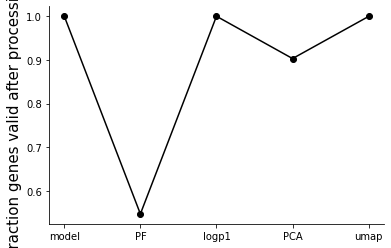

In [31]:
fig, ax = plt.subplots()

labels = ['model', 'PF', 'logp1', 'PCA', 'umap']
plt.scatter(labels, f_val_genes, color='black')
plt.plot(labels, f_val_genes, color='black')
#plt.xlabel(labels, fontsize=20)
plt.ylabel('fraction genes valid after processing', fontsize=15)
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('results/num_valid_genes.png', bbox_inches='tight')
plt.show()

## 2. Plot ground truth noise decomposition

### ...

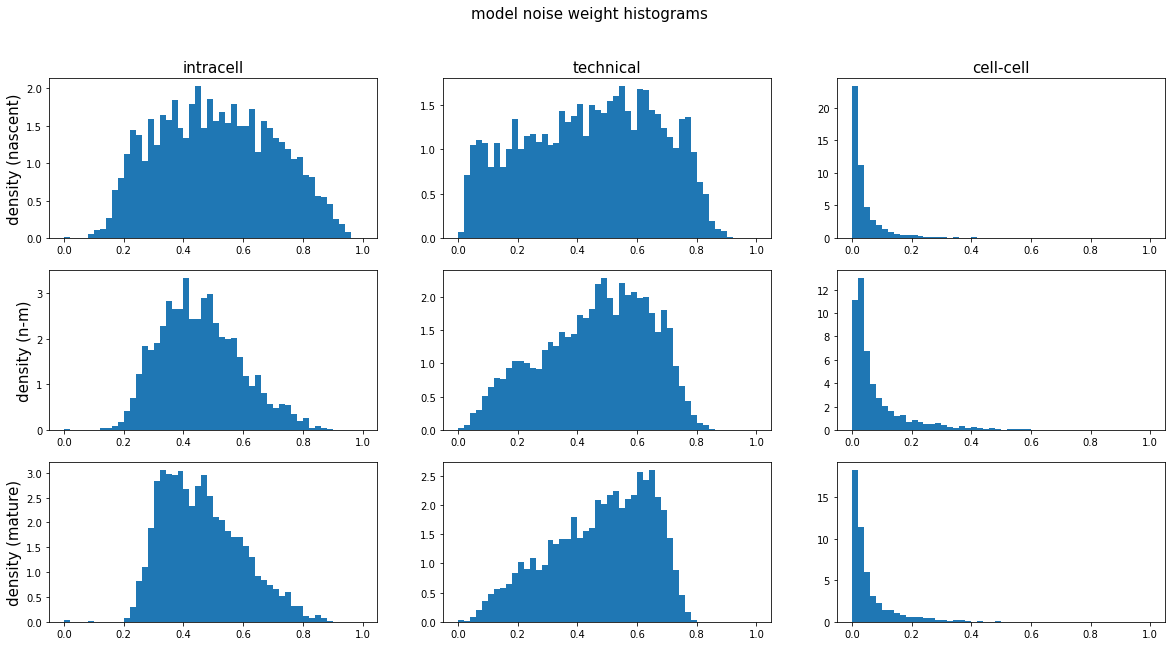

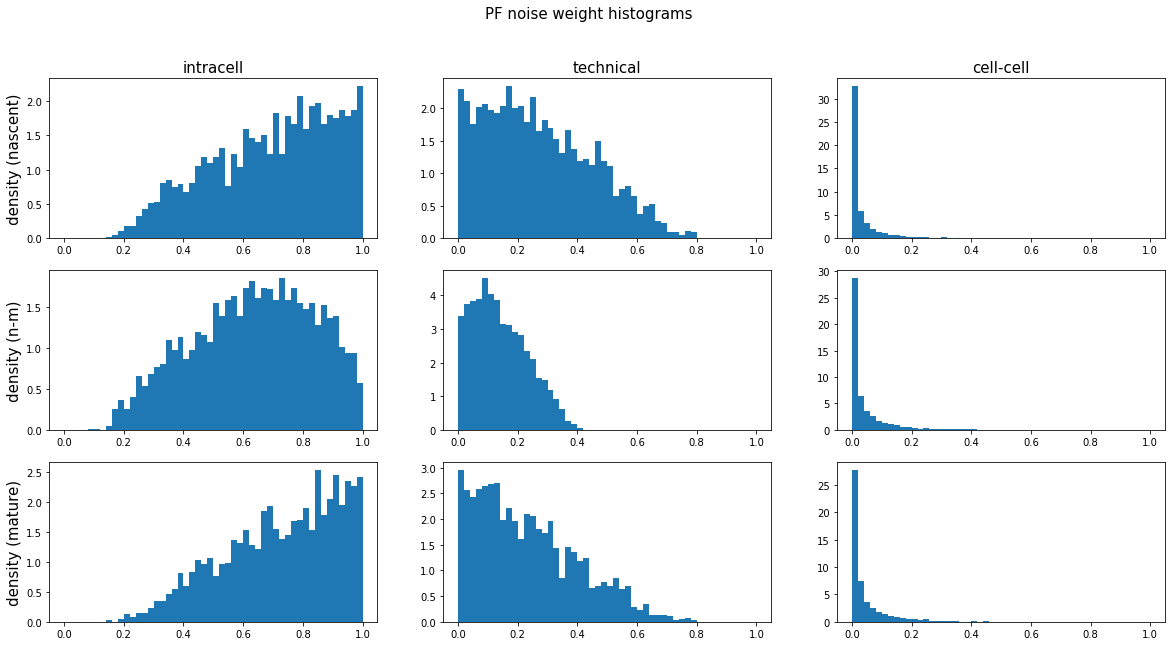

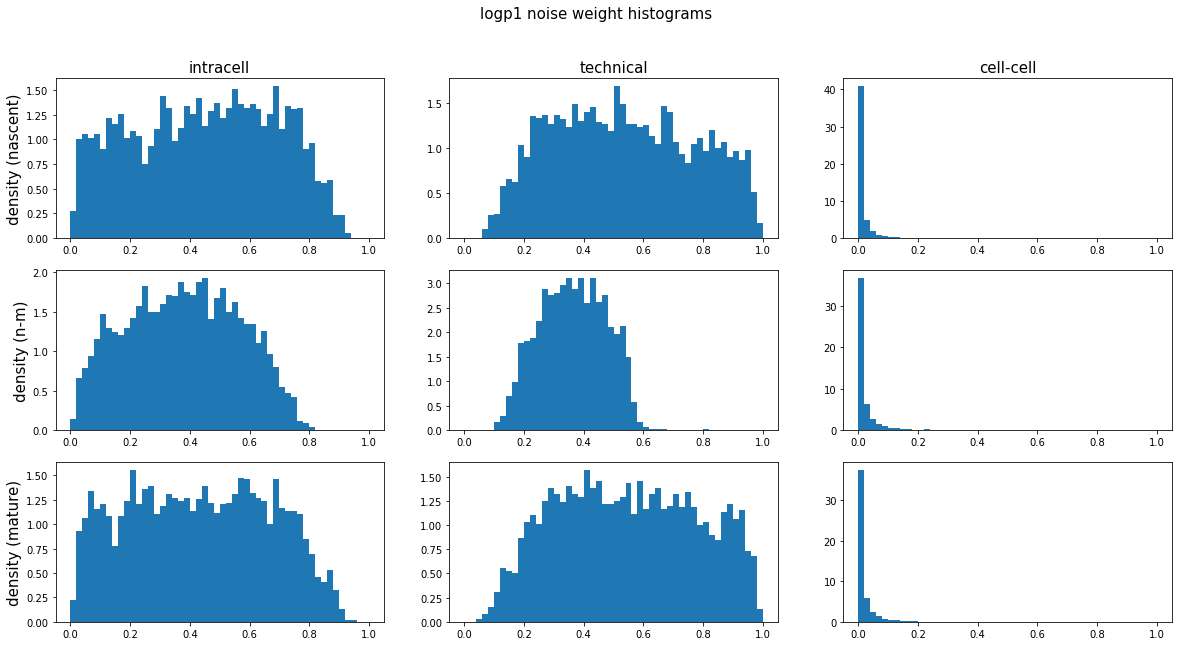

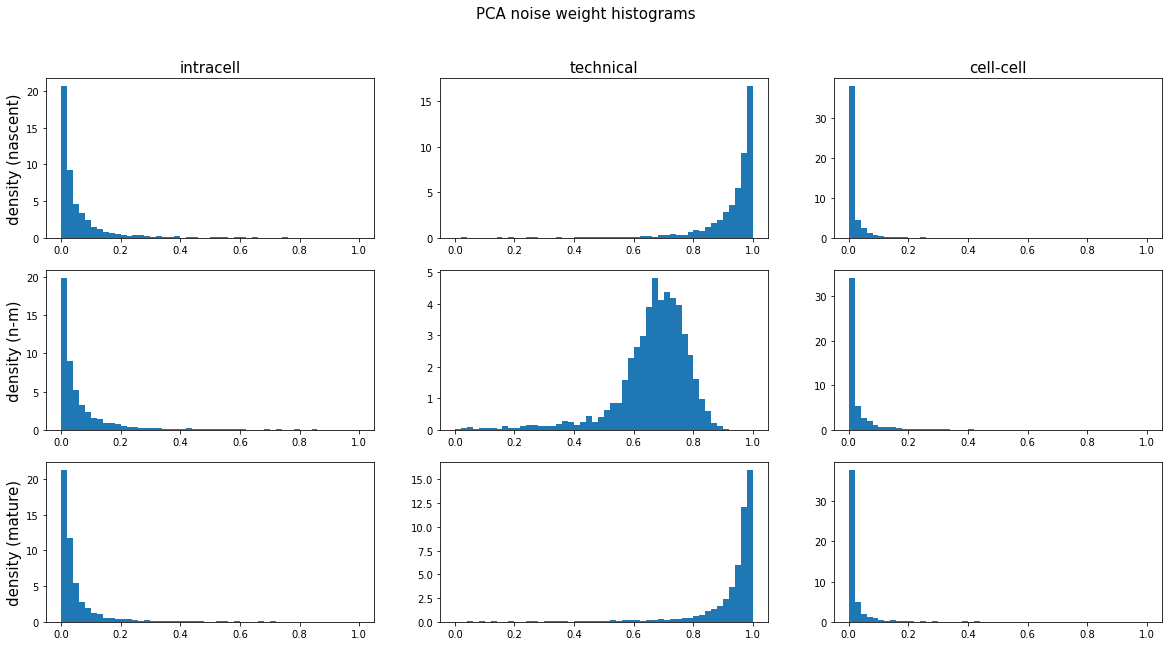

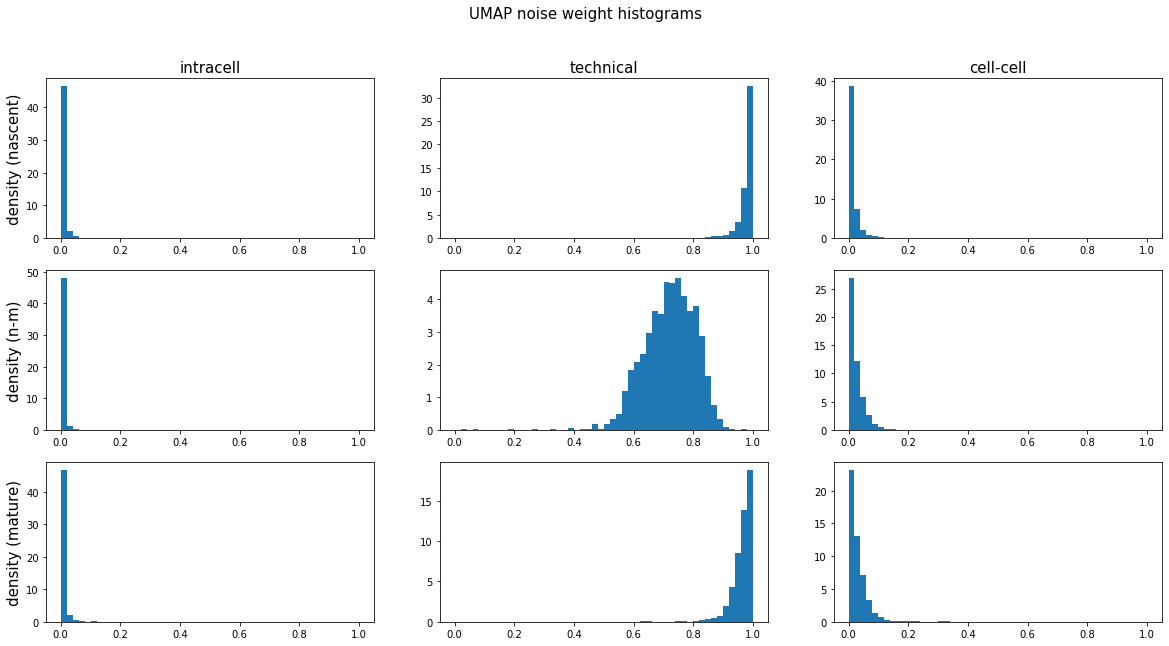

In [32]:
plot_noise_weight_histograms(f_model, name='model')
plot_noise_weight_histograms(f_PF, name='PF')
plot_noise_weight_histograms(f_logp1, name='logp1')
plot_noise_weight_histograms(f_PCA, name='PCA')
plot_noise_weight_histograms(f_umap, name='UMAP')

## 3. Compare model-based and empirical noise decompositions

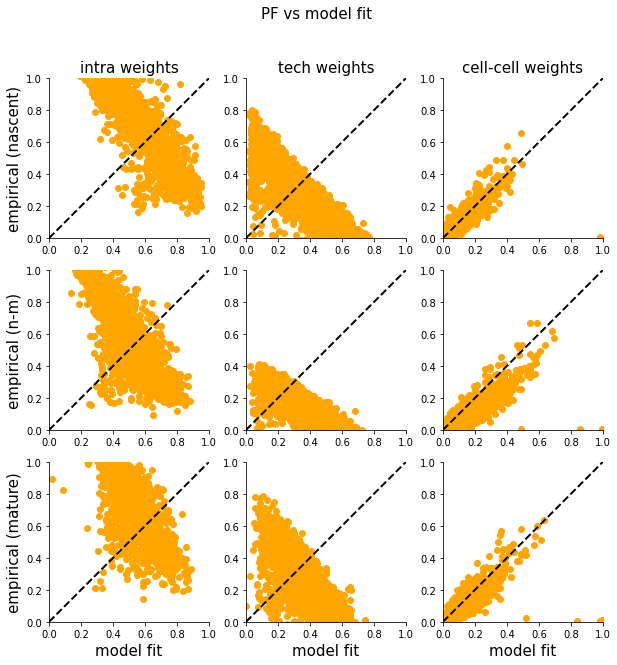

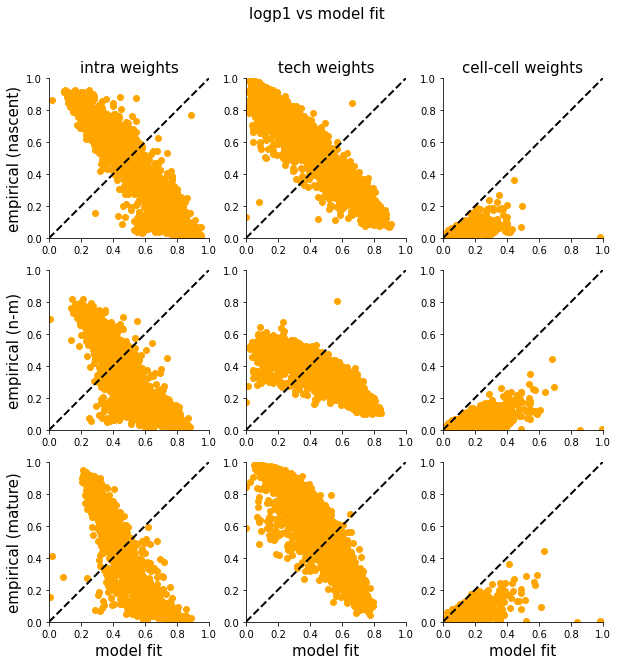

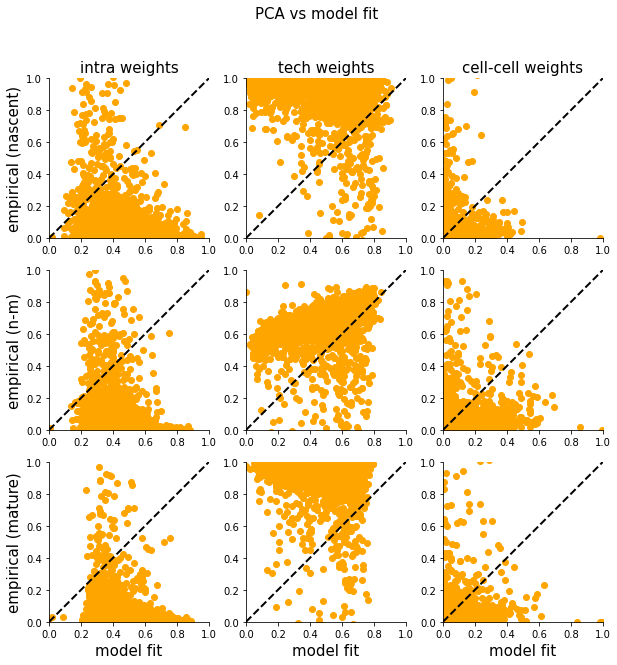

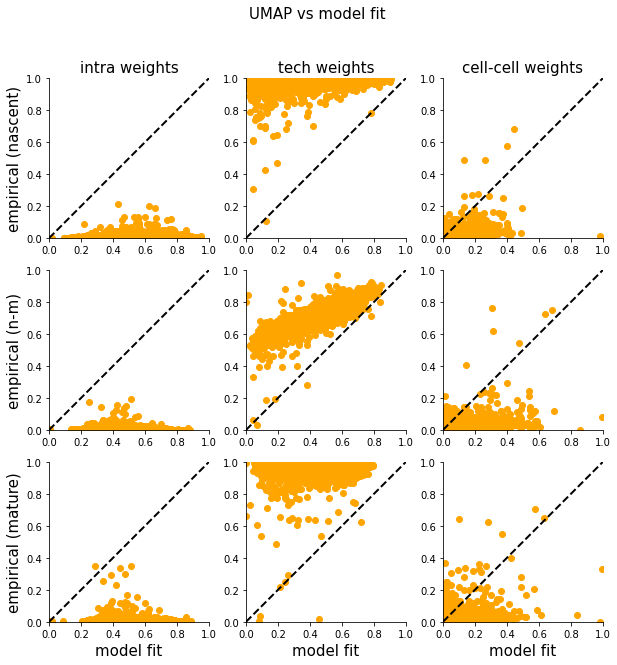

In [33]:
compare_noise_attributions(f_PF, f_model, ['PF', 'model fit'])
compare_noise_attributions(f_logp1, f_model, ['logp1', 'model fit'])
compare_noise_attributions(f_PCA, f_model, ['PCA', 'model fit'])
compare_noise_attributions(f_umap, f_model, ['UMAP', 'model fit'])

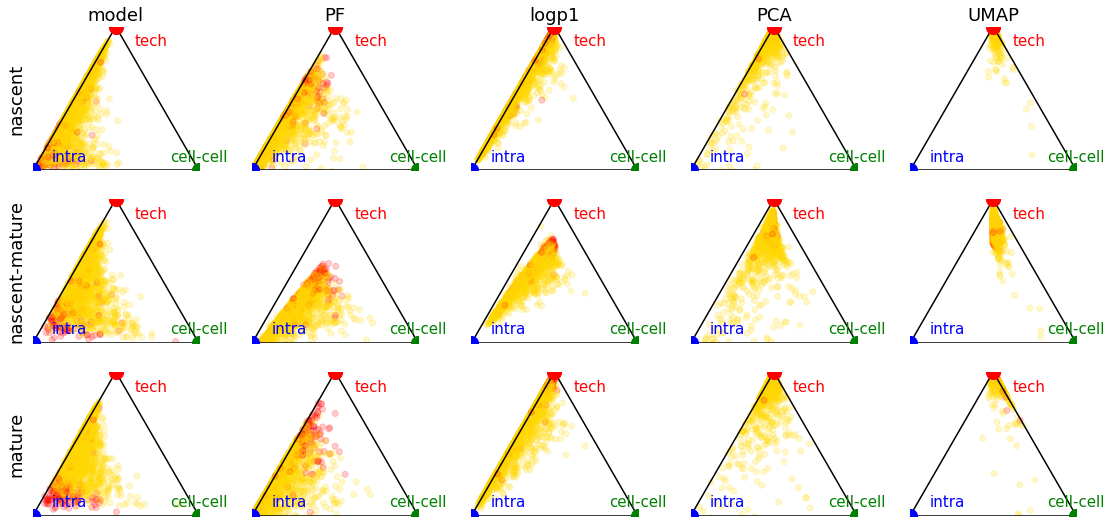

In [34]:
#f_list = [f_model, f_PF, f_logp1, f_PCA]
#labels = ['model', 'PF', 'logp1', 'PCA']
f_list = [f_model, f_PF, f_logp1, f_PCA, f_umap]
labels = ['model', 'PF', 'logp1', 'PCA', 'UMAP']

compare_triangles(f_list, labels, mask=mask)

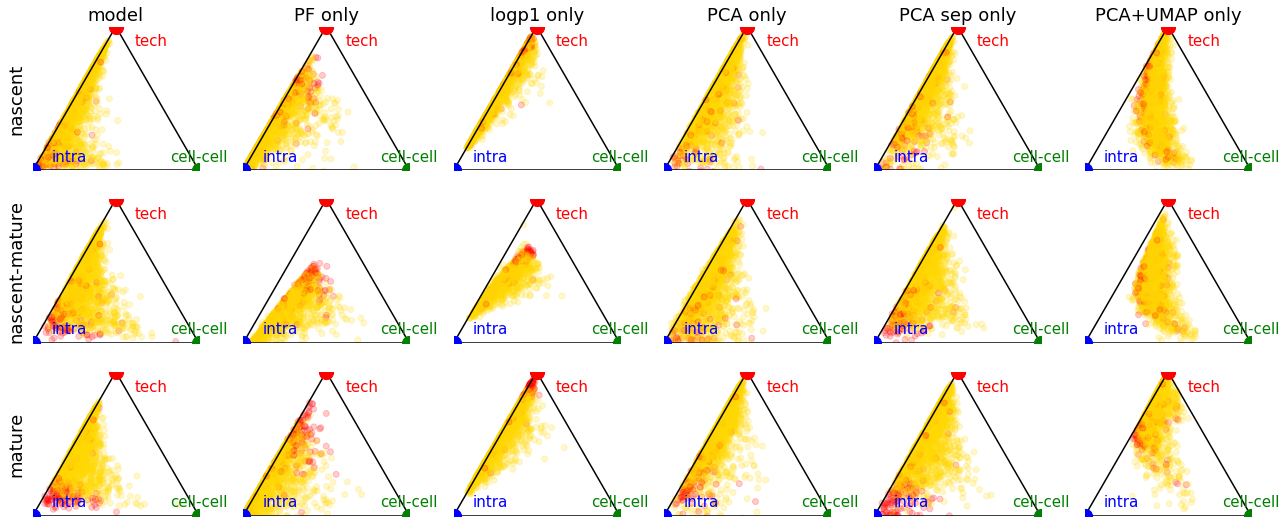

In [35]:
# control: try doing transforms individually, not in series
f_list = [f_model, f_PF, f_logp1only, f_PCAonly, f_PCAsep, f_umaponly]
labels = ['model', 'PF only', 'logp1 only', 'PCA only', 'PCA sep only', 'PCA+UMAP only']
compare_triangles(f_list, labels, name='control', mask=mask)

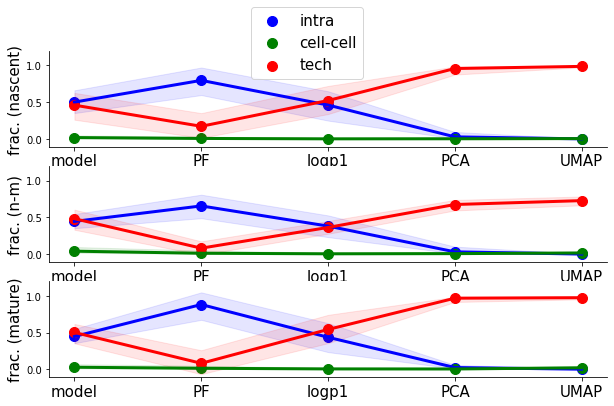

In [36]:
#f_list = [f_model, f_PF, f_logp1, f_PCA]
#labels = ['model', 'PF', 'logp1', 'PCA']
f_list = [f_model, f_PF, f_logp1, f_PCA, f_umap]
labels = ['model', 'PF', 'logp1', 'PCA', 'UMAP']

plot_weight_differences(f_list, labels)

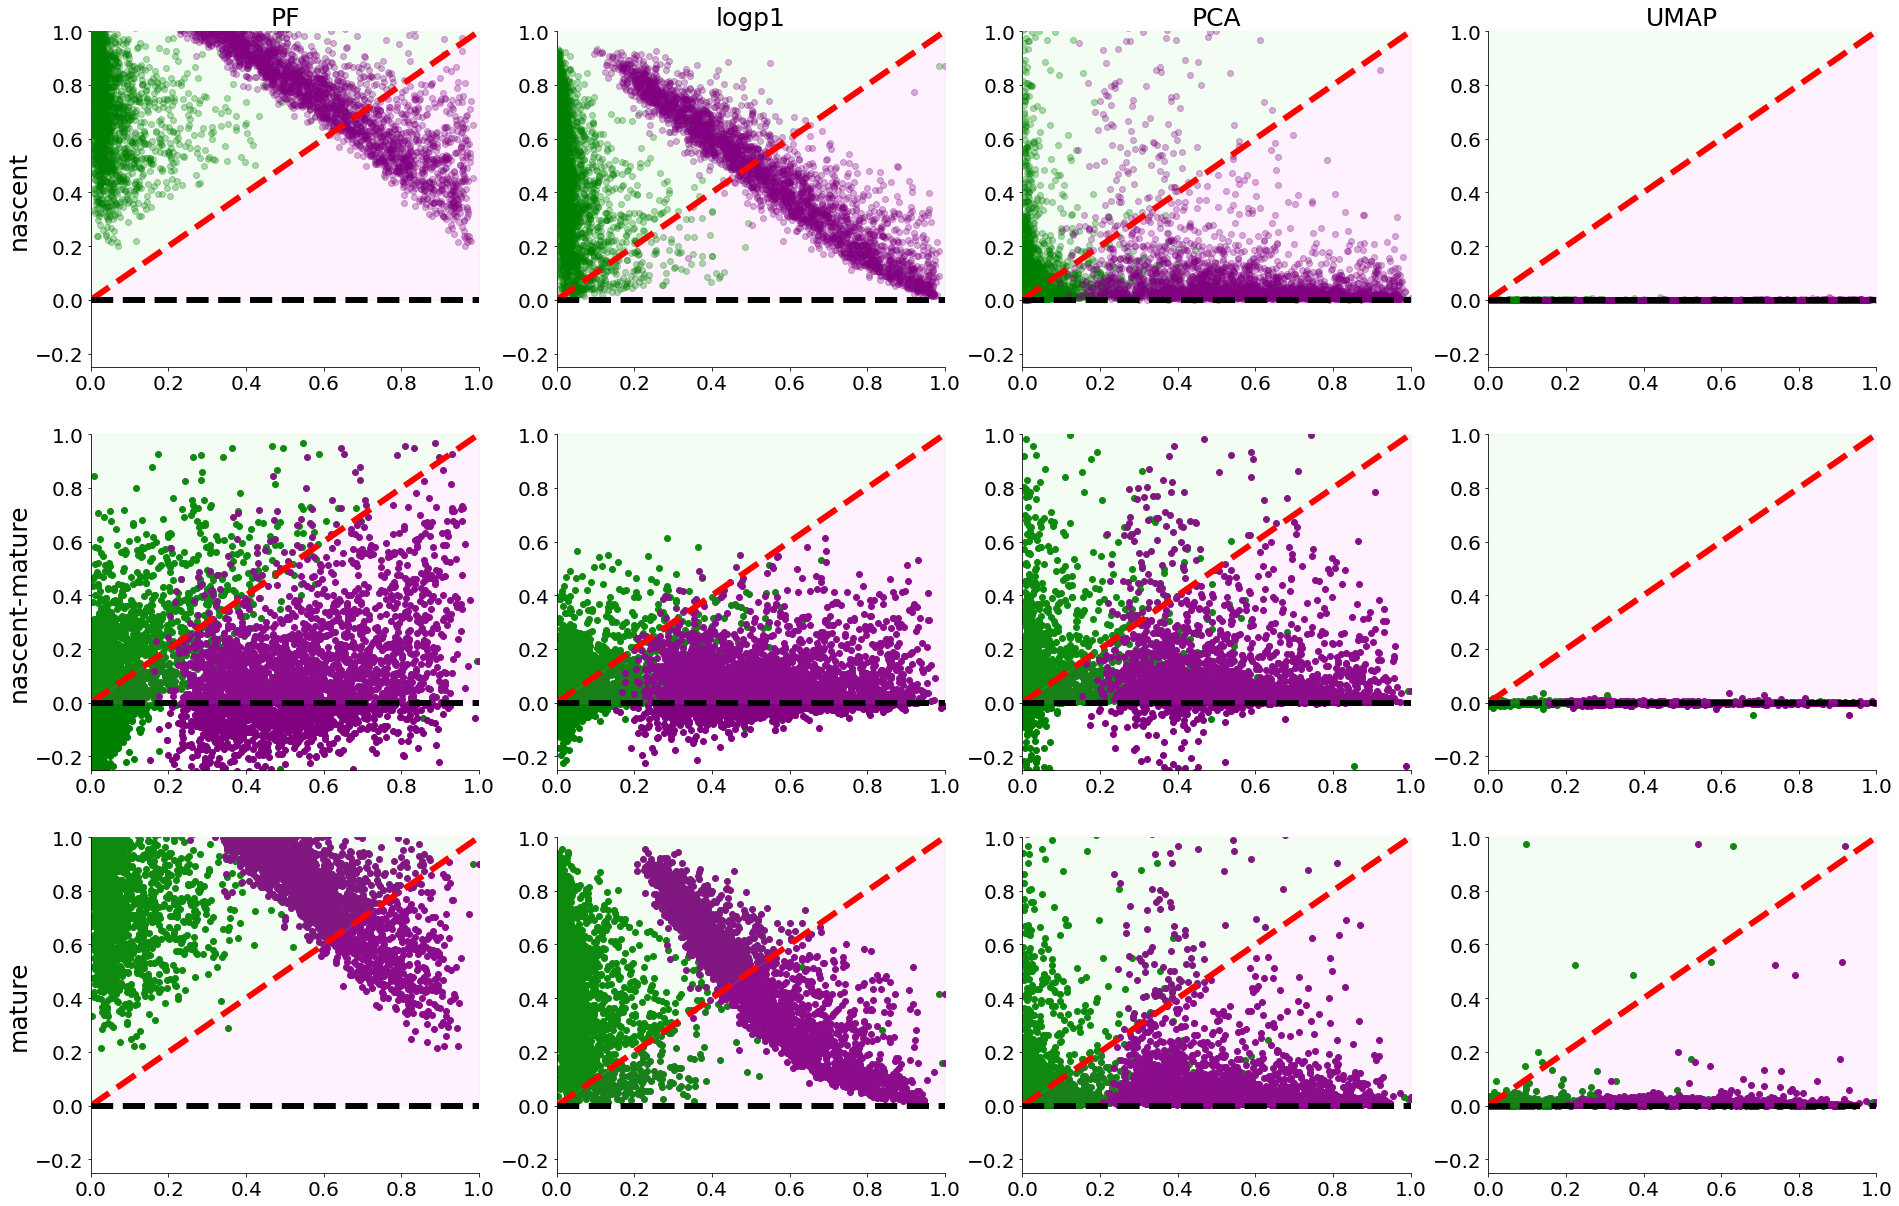

In [37]:
V_list = [V_PF, V_logp1, V_PCA, V_umap]
labels = ['PF', 'logp1', 'PCA', 'UMAP']
plot_lax_bounds(mom_model, f_model, V_raw, V_list, labels)

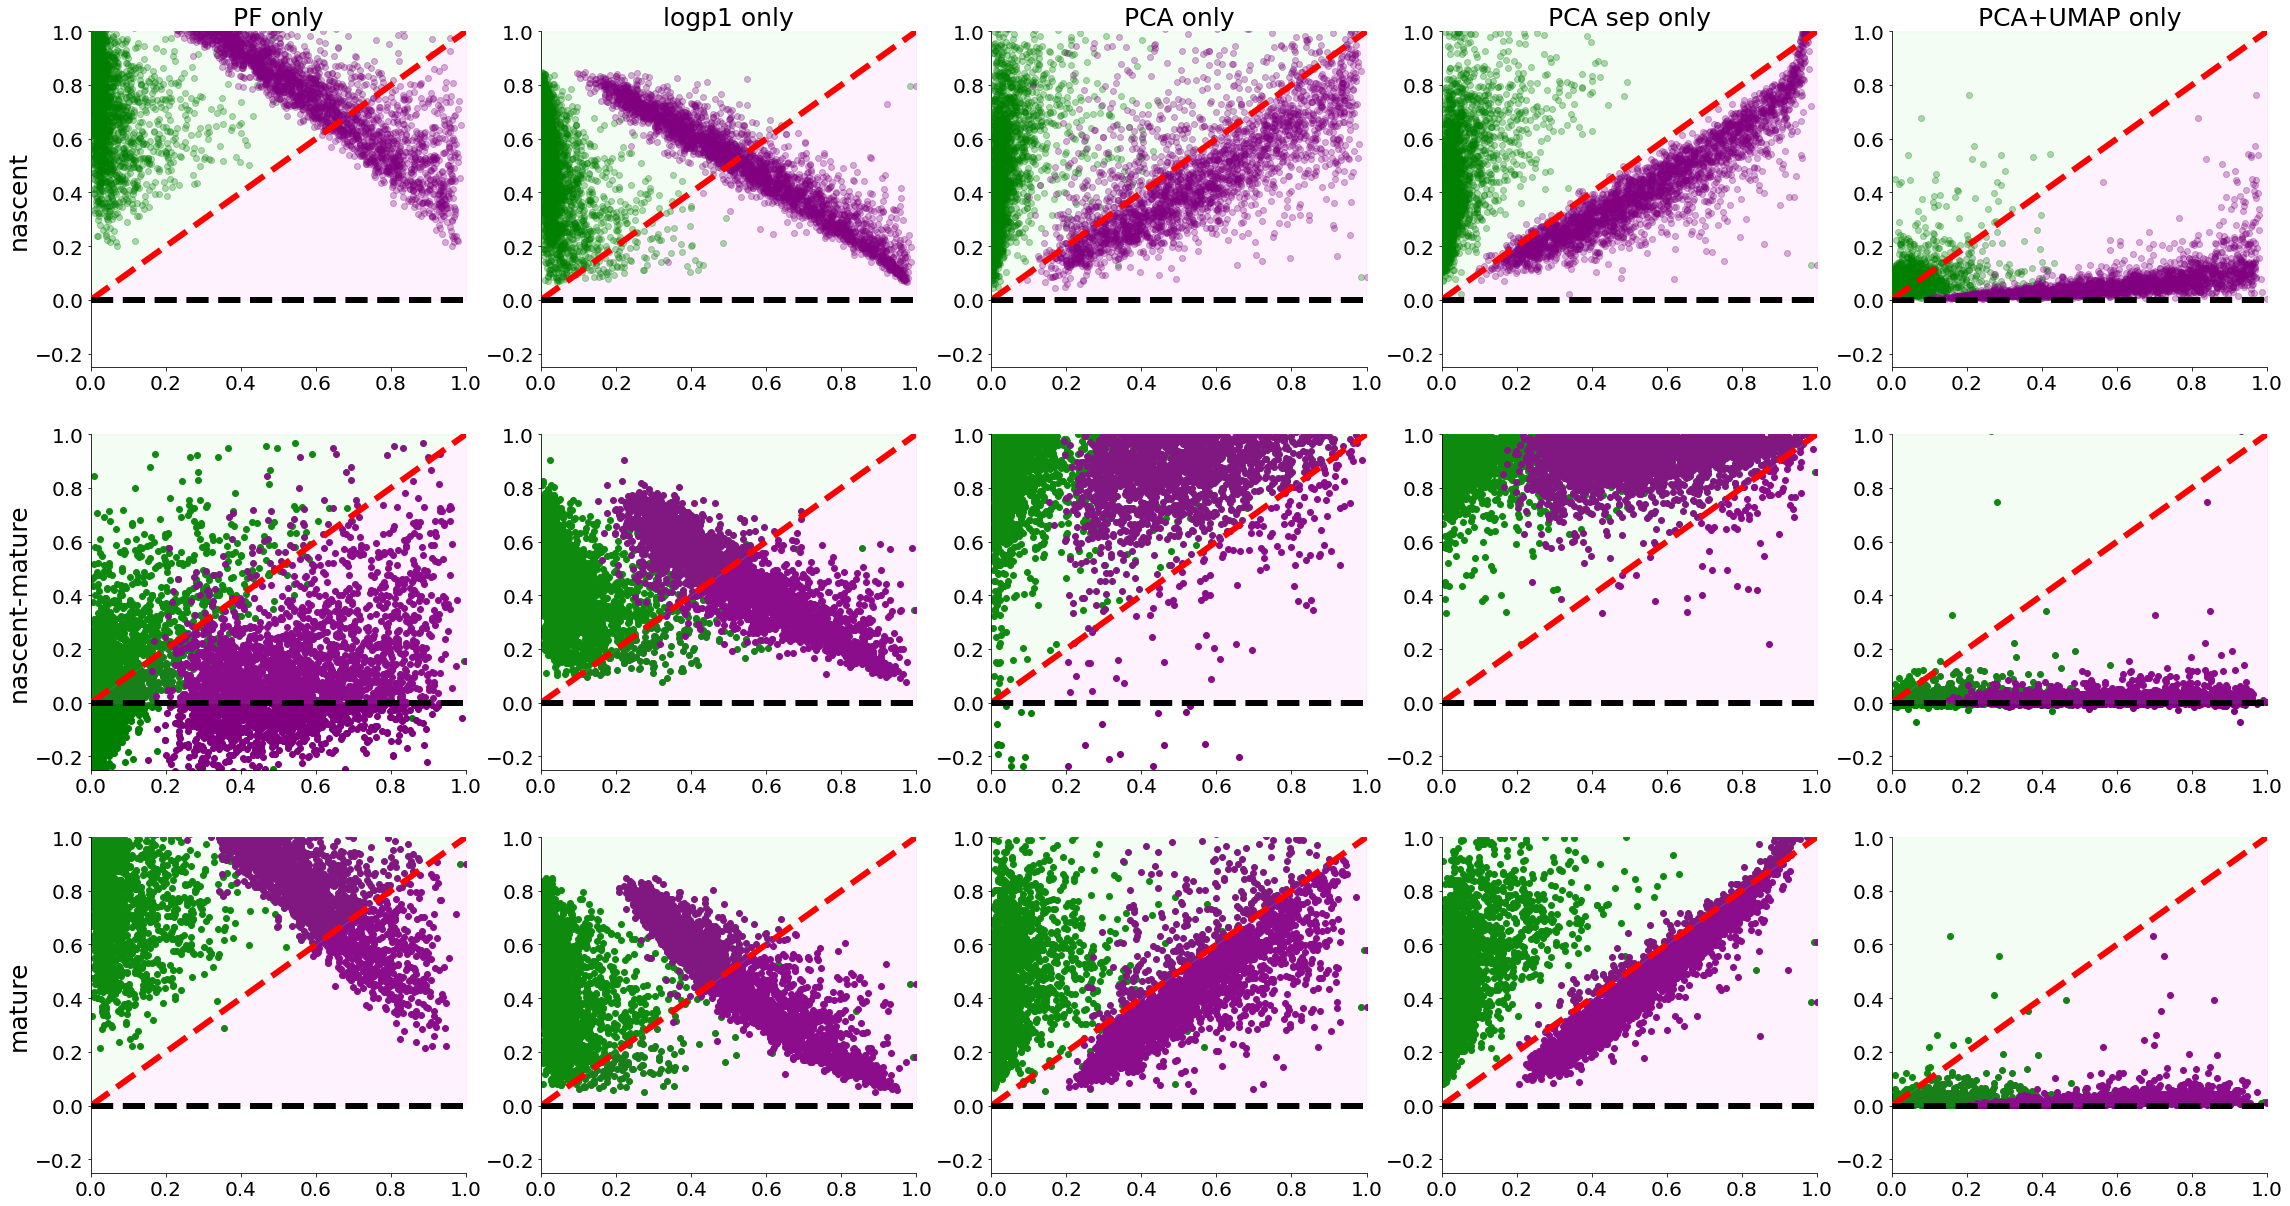

In [38]:
V_list = [V_PF, V_logp1only, V_PCAonly, V_PCAsep, V_umaponly]
labels = ['PF only', 'logp1 only', 'PCA only', 'PCA sep only', 'PCA+UMAP only']
plot_lax_bounds(mom_model, f_model, V_raw, V_list, labels, name='control')

### Sanity check, check distribution of nascent and mature means

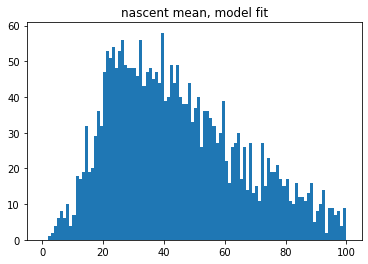

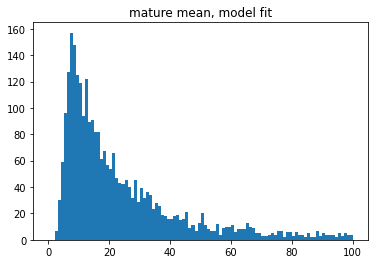

In [39]:
b_avg = np.mean(b, axis=0)
beta_avg = np.mean(beta,axis=0)
gamma_avg = np.mean(gamma, axis=0)

plt.hist(b_avg/beta_avg,bins=100, range=(0,100))
plt.title('nascent mean, model fit')
plt.show()



plt.hist(b_avg/gamma_avg,bins=100, range=(0,100))
plt.title('mature mean, model fit')
plt.show()

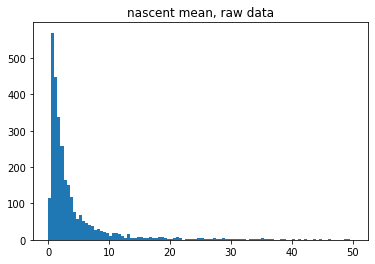

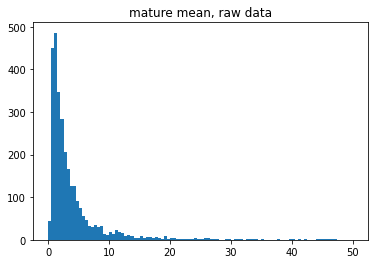

In [40]:
mu_N_emp = np.mean(S_N, axis=1)
mu_M_emp = np.mean(S_M, axis=1)

plt.hist(mu_N_emp, bins=100, range=(0,50))
plt.title('nascent mean, raw data')
plt.show()

plt.hist(mu_M_emp, bins=100, range=(0,50))
plt.title('mature mean, raw data')
plt.show()

## Misc

In [41]:
gene_list = ['Nf1', 'Ube2k', 'Rbm25', 'Ywhaq', 'Pnisr']
x_max = 30
bins = np.arange(0, x_max+2) - 0.5
print(bins)

[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5
 27.5 28.5 29.5 30.5]


NameError: name 'gene_names' is not defined

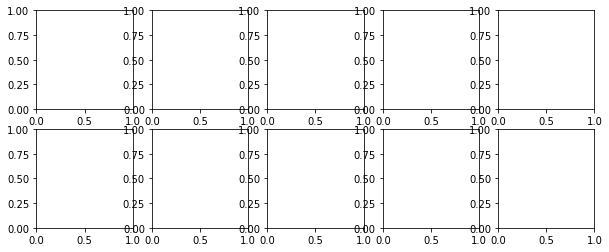

In [42]:
n_show_genes = len(gene_list)
fig, ax = plt.subplots(nrows=2, ncols=n_show_genes, figsize=(10,4))

i = 0
for g in gene_list:
    ind = list(gene_names).index(g)

    ax[0,i].hist(S_N[ind,:],bins=bins,ec='black', color='lightblue', alpha=0.5)
    ax[1,i].hist(S_M[ind,:],bins=bins,ec='black', color='lightblue', alpha=0.5)
    ax[0,i].set_title(g, fontsize=15)
    ax[1,i].set_xlabel('RNA count', fontsize=15)
    i+=1

for i in range(2):
    for j in range(n_show_genes):
        ax[i,j].spines[['right', 'top']].set_visible(False)
ax[0,0].set_ylabel('# cells', fontsize=15)
ax[1,0].set_ylabel('# cells', fontsize=15)
plt.show()

In [ ]:
from scipy.stats import poisson, nbinom

x_max = 30
bins = np.arange(0, x_max+2) - 0.5
x_ = np.arange(x_max+1)

ind = list(gene_names).index('Nf1')
x_N = S_N[ind,:]

mu_N = np.mean(x_N)
var_N = np.var(x_N)

pss_poiss = poisson.pmf(x_, mu=mu_N)
print(mu_N)
print(x_)


p = mu_N/var_N
k = (mu_N**2)/(var_N - mu_N)

pss_bursty = nbinom.pmf(x_, n=k, p=p)

In [ ]:
cond = [0, 1, 2]

for c in cond:
    fig, ax = plt.subplots(figsize=(10,4))
    
    
    plt.hist(x_N,bins=bins,ec='black', color='lightblue', alpha=0.5, density=True)
    if c > 0:
        plt.plot(x_, pss_poiss, color='red', linewidth=4)
        if c > 1:
            plt.plot(x_, pss_bursty, color='blue', linewidth=4)
    
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel('RNA count', fontsize=20)
    ax.set_ylabel('probability', fontsize=20)
    plt.xticks(fontsize=15); plt.yticks(fontsize=15)
    plt.ylim(0, 0.16)
    plt.savefig('results/nf1_hist_'+str(c)+'.svg',bbox_inches='tight')
    
    
    plt.show()